Run the following cell to import the required packages:

In [2]:
from itertools import product
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

We'll do the simplest example possible right now, a binary classifier for dogs with just one predictor variable (weight). Let's read the data in, where 1 corresponds to healthy and 0 corresponds to unhealthy:

In [3]:
df = pd.read_csv("data/dogweights.csv")
df.head()

,weight,health status
0,50,1
1,50,1
2,52,1
3,50,1
4,48,0


Let's create our logistic regression model and calculate its score (which returns the mean accuracy on the given test data and labels). We see that out of 20 dogs, it classifies 85% correctly, meaning only 3 dogs got classified incorrectly:

In [28]:
X = df.drop(columns = ["health status"])
y = df["health status"]

model = LogisticRegression(solver="lbfgs")
model.fit(X, y)
print(model.score(X,y))

0.85


Let's visualize which ones may have gotten classified incorrectly. Don't focus on the code too much, just the picture:

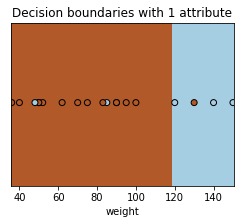

In [29]:
X = df.drop(columns = ["health status"])
Q = X
Q['dummy'] = 0
y = df["health status"]
h = .02  # meshsize
x_min, x_max = Q['weight'].min() - .5, Q['weight'].max() + .5 
y_min, y_max = Q['dummy'].min() - .5, Q['dummy'].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q['weight'], Q['dummy'], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 1 attribute')
plt.xlabel('weight')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.yticks(());

To see exactly which ones are misclassified, we can create a confusion matrix. We see that two unhealthy dogs were classfied incorrectly as healthy and one healthy dog was classified incorrectly as not healthy:

In [30]:
model.fit(X, y)
confusion_matrix(y, model.predict(X))

array([[ 3,  2],
       [ 1, 14]])

To view the matrix more clearly, we can use the following code (again, don't focus too much on the actual code):

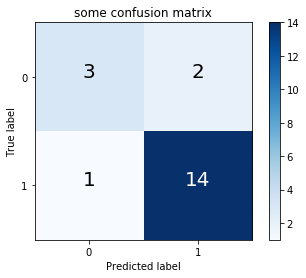

In [31]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm, classes=[0, 1], title='some confusion matrix',
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(confusion_matrix(y, model.predict(X)))

What are the actual model coefficients?

In [32]:
print(model.intercept_)
print(model.coef_)

[4.3727885]
[[-0.03673668  0.        ]]


This means that our model is given by:

$P(\text{dog is healthy}) = \frac{e^{4.373-0.0367(\text{weight})}}{1+e^{4.373-0.0367(\text{weight})}}$

What is the decision boundary separating from healthy and not healthy? Approximately 119 pounds, since 

$P(\text{dog is healthy}) = \frac{e^{4.373-0.0367(119)}}{1+e^{4.373-0.0367(199)}} \approx 50\%$

We can see that by predicting a dog weighing 118 pounds and 120 pounds:

In [38]:
X = df.drop(columns = ["health status"])
y = df["health status"]

model = LogisticRegression(solver="lbfgs")
model.fit(X, y)

print(model.predict([[118]]))
print(model.predict([[120]]))

[1]
[0]


Of course, we have violated the cardinal rule of machine learning which is that we didn't first break things up into a test/train split and only measure our success by the testing set accuracy. Let's do that now:

In [39]:
model = LogisticRegression(solver="lbfgs")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# scores output is negative, which is because
# Scikit-learn uses negative mean squared error so that 
# scores always improve with higher values 
print(-scores)
print('Average MSE: ', np.mean(-scores))

[0.25 0.25 0.   0.25 0.25]
Average MSE:  0.2


Notice that in each testing set of 4 dogs, there was one dog that was misclassified except in the third iteration where all four dogs were classified correctly.

### The Iris Example
We'll do a Multinomial Logistic Regression now, in which we use the famous iris dataset to classify irises by their measurements as Iris Setosa, Iris Versicolour, Iris Virginica. Let's read the dataset in:

In [40]:
iris = load_iris()

X = pd.DataFrame(iris.data,
                 columns = iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


The target variable is the categorical type of iris, where 0, 1, and 2 correspond to Iris Setosa, Iris Versicolour, and Iris Virginica, respectively.

In [41]:
y = iris.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let's create our logistic regression model and calculate its score (which returns the mean accuracy on the given test data and labels). We see that out of 150 irises, it classifies 96% correctly, meaning only 6 irises got classified incorrectly:

In [42]:
model = LogisticRegression()

model.fit(X, y)

print(model.score(X,y))

0.96


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


What is the actual model?

In [43]:
print(model.intercept_)
print(model.coef_)

[ 0.26421853  1.09392467 -1.21470917]
[[ 0.41021713  1.46416217 -2.26003266 -1.02103509]
 [ 0.4275087  -1.61211605  0.5758173  -1.40617325]
 [-1.70751526 -1.53427768  2.47096755  2.55537041]]


This means that our model is given by:

$P(\text{Iris Setosa}) = \frac{e^{0.264+0.410(\text{s length})+1.46(\text{s width})-2.26(\text{p length})-1.02(\text{p width})}}{1+e^{0.264+0.410(\text{s length})+1.46(\text{s width})-2.26(\text{p length})-1.02(\text{p width})}}$


$P(\text{Iris Versicolour}) = \frac{e^{1.09+0.43(\text{s length})-1.6(\text{s width})+0.58(\text{p length})-1.4(\text{p width})}}{1+e^{1.09+0.43(\text{s length})-1.6(\text{s width})+0.58(\text{p length})-1.4(\text{p width})}}$


$P(\text{Iris Virginica}) = \frac{e^{-1.2-1.7(\text{s length})-1.5(\text{s width})+2.5(\text{p length})+2.6(\text{p width})}}{1+e^{-1.2-1.7(\text{s length})-1.5(\text{s width})+2.5(\text{p length})+2.6(\text{p width})}}$


Let's see how this works in practice. The first iris in our training set has these properties and our model predicts it be Class 0 (the Iris Setosa).

In [44]:
print(X.iloc[0])
print('\n predicton:', model.predict([X.iloc[0]]))

sepal length (cm)    5.1
sepal width (cm)     3.5
petal length (cm)    1.4
petal width (cm)     0.2
Name: 0, dtype: float64

 predicton: [0]


If we plug this iris' properties into the three regression models above, we see that the largest probability is the first one, the iris setosa. Therefore, this data point gets classified as an iris setosa:

In [45]:
def prob_function(intercept, coeff, X):
    term = np.exp(intercept+X[0]*coeff[0]+X[1]*coeff[1]+X[2]*coeff[2]+X[3]*coeff[3])
    return term/(1+term)

print(prob_function(model.intercept_[0], model.coef_[0], X.iloc[0]))
print(prob_function(model.intercept_[1], model.coef_[1], X.iloc[0]))
print(prob_function(model.intercept_[2], model.coef_[2], X.iloc[0]))

0.9838989815463853
0.13666411838387435
1.2096525154577064e-05


We can't visualize in 2D exactly which 6 got classified incorrectly, because there are four explanatory variables. However, we can make a good guess of which might be those 6 if we visualize the decision boundary between just sepal width and height. Don't pay too much attention to the code, just view the picture:

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(1.5, 4.900000000000003)

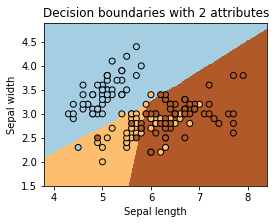

In [46]:
# Plot the decision boundary in 2-d 
# For that, we will assign a color to each point in the 
# mesh [x_min, x_max] x [y_min, y_max].

Q = X.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

To see exactly which ones were mislabeled, we can view a confusion matrix. We can see that five Iris Versicolours were incorrectly mislabeled as Iris Virginica and one Iris Virginica was incorrectly mislabeled as a Iris Versicolours.

In [47]:
model.fit(X, y)
confusion_matrix(y, model.predict(X))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[50,  0,  0],
       [ 0, 45,  5],
       [ 0,  1, 49]])

There is actually a nice piece of code that visualizes this confusion matrix more clearly. Don't focus too much on the code, just the results:

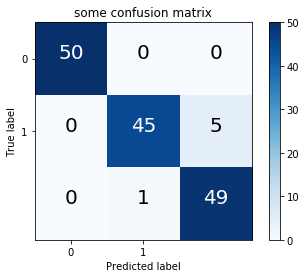

In [48]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm, classes=[0, 1], title='some confusion matrix',
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(confusion_matrix(y, model.predict(X)))

Of course, we've violated one of the biggest rules in all of machine learning which is to evaluate our accuracy on the test data not the training set. So let's first do a test/train split and then view the confusion matrix of the testing data:

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train_score=0.9619047619047619
test_score=0.9555555555555556


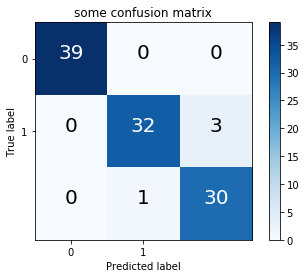

In [52]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

model = LogisticRegression()

model.fit(X_train, y_train)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print(f"train_score={acc_train}")
print(f"test_score={acc_test}")

plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)))

### Logistic Regression - Digit example
Another famous dataset used as an example for classifications is the digit dataset. Let's load it in the data. If you'd like to read the descriptions of what the data is, you can uncomment the two print statements below:

In [53]:
digits = load_digits()
#print(digits.DESCR)
#print(load_digits.__doc__)

There are 1797 images in the dataset. Since each image is 8 pixels wide by 8 pixels high, there are 64 attributes for each image. Each attribute takes on an integer value from 0 through 16, indicating black to white. Using these 64 numerical attributes, we'd like to predict the category (i.e., is the digit 0, 1, 2, ..., or 9)? Let's view one of the images' numerical data:

In [54]:
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


And its corresponding image:

<Figure size 432x288 with 0 Axes>

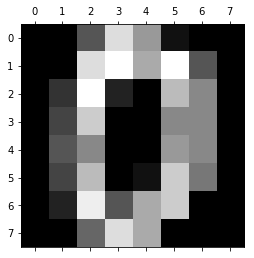

In [55]:
plt.gray()
plt.matshow(digits.images[0])

Let's view the digits 0 through 4:

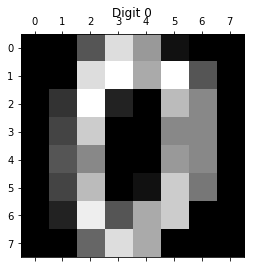

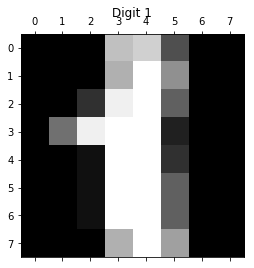

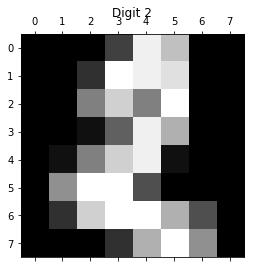

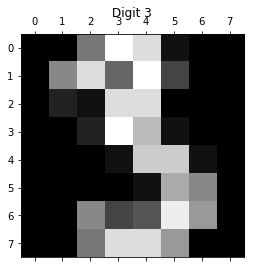

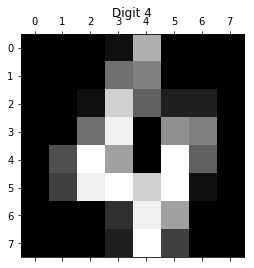

In [127]:
for i in range(5):
    image = digits.images[i]
    digitname = digits.target[i]
    plt.matshow(image)
    plt.title("Digit %s" % digitname)

Let's use Logistic Regression to predict the digits:

In [56]:
X, y = digits.data, digits.target
model = LogisticRegression()
model.fit(X, y)
model.score(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.993322203672788

How can we figure out which ones we got wrong? We can print a classification report. For our purposes, we will just look at the precision and recall categories. Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.

Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12. When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are".

In the report below, we see we had the worst time predicting 1' and 8's. 97% of the digits predicted as 1's were actually 1's, and the algorithm was able to find 98% of all of the 1's.

In [57]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.97      0.98      0.98       182
           2       1.00      1.00      1.00       177
           3       0.98      1.00      0.99       183
           4       1.00      1.00      1.00       181
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       179
           8       0.98      0.97      0.97       174
           9       1.00      0.98      0.99       180

   micro avg       0.99      0.99      0.99      1797
   macro avg       0.99      0.99      0.99      1797
weighted avg       0.99      0.99      0.99      1797



We can see from the confusion matrix below that out of all the 1's, one was incorrectly labeled as a 3 and two were labeled as an 8. Out of the 8's, five were labeled incorrectly as a 1 and one as labeled as a 3.

In [58]:
confusion_matrix(y, model.predict(X))

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 179,   0,   1,   0,   0,   0,   0,   2,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 183,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 182,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0,   0],
       [  0,   5,   0,   1,   0,   0,   0,   0, 168,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   2, 177]])

## Gradient Boosting Classifier

A classifying technique that typically provides greater accuracy than logistic regression is the gradient boosting classifer. Let's try it out on the digit dataset:

In [59]:
X, y= digits.data, digits.target
model = GradientBoostingClassifier()
model.fit(X, y)
model.score(X,y)

1.0

Wow! Did that really say 100% accuracy? Let's check our confusion matrix:

In [60]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       177
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       181
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       179
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00       180

   micro avg       1.00      1.00      1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797



Gradient boosting is usually the way to go!

### Homework

Edit your previous gradient descent algorithm to now find the optimal parameters for a logistic regression with one explanatory variable.

-120.000079 1.9921
-120.000054620721 1.993270205392
-120.00021367849514 1.9710021170132177
-120.00019122838732 1.9721246224046094
-120.00016883442721 1.9732443204100172
-120.00030435602004 1.9556265133435635
-120.00025375827016 1.957448032339087
-120.00038722626061 1.9400971935811315
-120.00036711092746 1.9411431909054537
-120.00034316771989 1.9423403512837365
-120.00031928439428 1.9435345175639132
-120.0004325082171 1.92994765882512
-120.00040800516753 1.931172811303468
-120.00057768068122 1.905721484249915
-120.00062819503712 1.901175192218752
-120.00060225316854 1.902472285647957
-120.00061442562628 1.9016202136060039
-120.0005857027821 1.9029989101262856
-120.0005598521419 1.904291442136109
-120.00053125757127 1.9056639815263303
-120.00059129511826 1.8999604145625244
-120.00056529254769 1.901260543090874
-120.00053655248847 1.9026400659336349
-120.00054873675653 1.9017871671692343
-120.00067496853953 1.8853770353798527
-120.00083777441986 1.860956153329087
-120.00094108832049 1.848

-120.00069171491288 1.2762069914514556
-120.00063297215675 1.2790266437454672
-120.00062708392171 1.279556584898623
-120.00062124338727 1.280082232998497
-120.00056424687767 1.2829320584781703
-120.00061002748103 1.2769805800419833
-120.00059501625914 1.278226511458355
-120.00058905605016 1.2787629302670058
-120.00064808227134 1.2704992593016196
-120.00059060658623 1.273373043557479
-120.00055874210867 1.2756035569865085
-120.00050152172777 1.2784645760311477
-120.0004316598093 1.281259052770367
-120.00042056639712 1.2822019928051849
-120.0003636760762 1.2850465088514917
-120.00043643268886 1.2741330169537446
-120.00044284555412 1.273491730427476
-120.00050113395353 1.265331354509475
-120.00042568538116 1.268047503114853
-120.00037062342564 1.2709107248020703
-120.00033858680575 1.27315328819418
-120.00037136486175 1.2692199214746005
-120.0004290552794 1.261143263004779
-120.00040264059507 1.2631243643295231
-120.00045947760343 1.2551671831583477
-120.00049009720593 1.2514928308581799


-119.99262419170803 1.2178676313572887
-119.99259453915619 1.2200915727452821
-119.99251746985827 1.222866067470414
-119.99250142095653 1.2242302241178782
-119.99242939766407 1.2271111558161278
-119.99241370968292 1.2284446342141577
-119.99240327728629 1.2293835499108945
-119.9924676924155 1.2197212805294924
-119.99239548879903 1.2226094251883417
-119.99245888781732 1.2130995724449238
-119.99244707431995 1.2141627872080236
-119.99241714408193 1.2164075550605524
-119.99235553922743 1.2193645880766089
-119.99233919286188 1.2207540291485897
-119.99240231362705 1.2112859143716757
-119.9923963933866 1.2118483372142659
-119.9923662896155 1.2141061200469396
-119.99242841316722 1.204787587289326
-119.99240741810856 1.2065301771587826
-119.99237088281353 1.2090876478099721
-119.99230892664974 1.212061543671793
-119.99230914049518 1.21204015912774
-119.9923709542099 1.2027681019184402
-119.99229807256303 1.205683367793539
-119.9922916201849 1.2062963437160958
-119.9923405093814 1.199451856206086

-119.97773702538487 1.268204445420665
-119.97780727831466 1.2576665059525076
-119.97779949049291 1.2583674099093407
-119.97774143106392 1.261270381359092
-119.97772866130491 1.262355810875413
-119.97767080136678 1.2652488077812896
-119.97766369608868 1.2658882828103841
-119.97766930725327 1.2653271663518892
-119.97761159594228 1.2682127319013723
-119.97759587998743 1.269517156153767
-119.97753683921505 1.2723511132282281
-119.97758126732293 1.266575459203769
-119.977574281533 1.2672041802982776
-119.97761804050215 1.261515514307836
-119.9776017686718 1.262866076227131
-119.97760707767766 1.262335175641727
-119.97754921682936 1.2652282180565064
-119.97749403114749 1.2680978735141568
-119.97756426833448 1.2575622954647605
-119.97762034949157 1.249710933471218
-119.97756035799603 1.252590525257276
-119.97750451514298 1.255494353615596
-119.97744882334486 1.2583903271182069
-119.97745368492875 1.2579041687293593
-119.97739811849183 1.2607936234487314
-119.97732757283865 1.263615449575953
-

-119.96908236862683 1.2873629826094943
-119.96907182539798 1.288259157061474
-119.9690613583545 1.2891488557568638
-119.9691347616215 1.2781383657060874
-119.96909303706542 1.2807252881835338
-119.9690783681713 1.2819428063953138
-119.96900867680519 1.284730461039808
-119.96895194431957 1.2875670853210488
-119.96902511043042 1.276592168692973
-119.96908386430893 1.2683666257020512
-119.96915415021891 1.2578237392034013
-119.96907846271938 1.2605484891868015
-119.96907724574739 1.260664101525849
-119.96910855636233 1.2569068277333666
-119.96910070886827 1.2576131021987988
-119.96903004429164 1.2604396852636355
-119.96898722252209 1.2630946349762282
-119.96901882489107 1.259302350699273
-119.96907515820133 1.251415687261052
-119.96900424575367 1.2542521851677624
-119.96894598935867 1.2571650049171306
-119.9689293651081 1.2585448177153733
-119.9689128553986 1.259915123603436
-119.96887000122341 1.2625720824653393
-119.96885382583625 1.263914639599337
-119.96889716588556 1.2582804331874669

-119.956600140044 1.306832549016131
-119.95653145674582 1.309579880943307
-119.95650217080603 1.311629896728657
-119.95656584248941 1.3027158610566882
-119.95664129330272 1.2913982390592862
-119.95662752271527 1.2925411978177508
-119.95667459644346 1.2864216131525839
-119.95667584982212 1.2863025421805439
-119.95666165625727 1.2874806080629972
-119.95666301025338 1.287351978432573
-119.95660899589325 1.2901607251594247
-119.95656802924921 1.2927006570896573
-119.95661512376661 1.2865783698286446
-119.95655849606997 1.2894097546602614
-119.95656003343817 1.2892637046815791
-119.95654966429304 1.290145082018097
-119.95649579528764 1.2929462702988634
-119.95643948610535 1.2957617294128807
-119.95648697869069 1.2895876933189967
-119.95643050158837 1.2924115484346337
-119.9563741657353 1.2952283410886265
-119.95634387534501 1.2973486684088937
-119.95628619173722 1.3001174815828962
-119.95634825189845 1.2914290590107147
-119.95638326703728 1.2872272423511881
-119.95637816110583 1.28768677618

-119.95195365546017 1.245829916981155
-119.95189499500236 1.2487629398714752
-119.95186770032785 1.2508100404593234
-119.95184055921318 1.2528456240592643
-119.95182359355942 1.2542537733215346
-119.9517653544245 1.2571657300679089
-119.95180783420405 1.2516433587258364
-119.951790768795 1.2530597876778131
-119.95177732708618 1.2542023329271885
-119.95170152659283 1.25693115068749
-119.95164342144884 1.259836407887101
-119.9517124452666 1.2494828352228584
-119.95177991597943 1.2393622282971342
-119.95177050680006 1.2402090544403654
-119.95176737488973 1.240506585922187
-119.95171092946482 1.2434417480173479
-119.95166707114227 1.246160964015596
-119.9516084275234 1.249093144959114
-119.95161238522947 1.2486973743522753
-119.95153638672255 1.2514333206009831
-119.95157812151784 1.2460077972131005
-119.95151947032959 1.2489403566261437
-119.95151092344221 1.2497095764898016
-119.95150244579318 1.2504725649033441
-119.95145902358976 1.253164741515495
-119.95145085695748 1.2538997384213426

-119.94074425955789 1.2247369229341147
-119.94070905039824 1.2272015641099066
-119.9406494697674 1.2301805956521517
-119.94063409446855 1.2314874960534952
-119.94063014514659 1.2318626816405869
-119.94062007215778 1.2327692506323613
-119.94060491692402 1.2340574455026758
-119.94067008493593 1.2242822437164043
-119.94061035837804 1.22726857161136
-119.94064896268199 1.222250012097717
-119.94060380153378 1.2250500032868998
-119.94057473968023 1.227229642303526
-119.94051516058761 1.2302085969347512
-119.94043850758193 1.232968105138905
-119.94046652331603 1.2296062170458146
-119.94046239544014 1.2299983652566913
-119.94040541489274 1.2329613537216
-119.9403446566323 1.2358777502225402
-119.94031022773017 1.238287773372414
-119.94030073331955 1.2391422703285933
-119.9402861201118 1.2403843929878013
-119.94033983364069 1.232864498942056
-119.94032985110576 1.2337629270856532
-119.94039497521497 1.2239943107038918
-119.94033523453552 1.2269813446758928
-119.94027564326753 1.22996090807593
-

-119.93099749648944 1.2814936379818007
-119.9309662700466 1.2836794889804441
-119.93090952305478 1.2865168385714953
-119.93087864832395 1.288678069729109
-119.93082472870493 1.2914818899182743
-119.93075029122824 1.2941616390791735
-119.93069665688317 1.2969506250222473
-119.93066651273027 1.2990607157256202
-119.93061053509955 1.3018595972619427
-119.93065884623665 1.2955791494377789
-119.93069438507574 1.2913144887474233
-119.93063802010579 1.2941327372448086
-119.93056885477726 1.296899350386021
-119.93056464514994 1.2972782168448243
-119.9305669560159 1.297058684579089
-119.93064158425163 1.285864449219462
-119.93070167463294 1.2774517958365557
-119.93062673219592 1.2801497235694383
-119.93055700755814 1.2829387090810151
-119.9306166884204 1.2745833883640854
-119.93055948697312 1.2774434607275962
-119.93056630075971 1.2767620820690175
-119.93049644067669 1.2795564853897374
-119.93049706804636 1.2794968852709594
-119.93049129226897 1.2800167052363889
-119.93048556328115 1.2805323141

-119.92138602593045 1.2263382383383161
-119.92145005528018 1.2167338358795936
-119.92137293624822 1.2195101210302837
-119.92137396588738 1.2194071571136056
-119.9213445000502 1.221617094902283
-119.92130909190234 1.2240956652522654
-119.9212932187248 1.2254448853436295
-119.92123356967585 1.2284273377912067
-119.92122934903936 1.2288282982567602
-119.92116986922493 1.2318022889785702
-119.92115981026106 1.232707595726074
-119.92110052448103 1.2356718847272719
-119.92104138697475 1.2386287600416777
-119.92109487395977 1.2311405821390373
-119.92109706692311 1.230921285805043
-119.9210401537329 1.233880771695706
-119.92103645136606 1.234232496545757
-119.92095996269948 1.2369860885424828
-119.92090089104394 1.2399396713192616
-119.92084048724728 1.2428390535593121
-119.92078022268136 1.2457317527232994
-119.920821247029 1.2403985875312242
-119.92081816407357 1.2406914682972228
-119.92075927782882 1.2436357805346834
-119.92074506611088 1.2448437765589357
-119.9206888772422 1.24776559773055

-119.9128074337686 1.2804409422972252
-119.91279279755938 1.2816557476627424
-119.91273596755396 1.2844972479334635
-119.91277019448773 1.2803900158793282
-119.91271330121833 1.2832346793493543
-119.91272071197297 1.2824936038859827
-119.9127152236766 1.2829875505585837
-119.91271619477868 1.2828952958610418
-119.91278871635687 1.2720170591333853
-119.9127568447623 1.2742480707537767
-119.91280158425465 1.268431936747857
-119.91278595130382 1.2697294716670942
-119.91271074877885 1.2724367625660606
-119.91271707974435 1.2718036660152778
-119.91265975721058 1.2746697927042268
-119.91260257804045 1.2775287512103266
-119.91256087222044 1.2801145120505126
-119.91256797111078 1.2794046230172296
-119.91255680793576 1.2803534928934746
-119.91262894840288 1.2695324228245617
-119.91255373894116 1.2722399634467236
-119.91249489390566 1.2750645251504116
-119.91250148786328 1.274405129388298
-119.91248989979779 1.275390114954936
-119.91249014936881 1.2753664057079486
-119.91243300519895 1.278223614

-119.90670640711063 1.2515317072878445
-119.90669813825788 1.252275904035453
-119.90662732259591 1.2551085305145266
-119.90665802899225 1.251423762953829
-119.90672583589867 1.2412527269917166
-119.90666699180919 1.2441949314660323
-119.90665284171138 1.245397689780494
-119.90658175096613 1.2482413195905135
-119.90651077403716 1.2510803967492075
-119.90648369855614 1.253111057825546
-119.90642394140322 1.2559794011658467
-119.90641607312538 1.2566875461711295
-119.90640826858846 1.2573899544937246
-119.90645082287428 1.2518578973376973
-119.90651869510805 1.2416770622710303
-119.90645987244247 1.244618195550108
-119.90648932016606 1.2410844687188796
-119.90643046790018 1.2440270820130908
-119.90637176282381 1.246962335831453
-119.90632816811687 1.249665207661812
-119.90625224973618 1.2523982693667346
-119.90619245860087 1.255268243862101
-119.90619080289157 1.2554255362448126
-119.90613266797759 1.2583322819443452
-119.90611972008888 1.2594328524840754
-119.90604919128326 1.26225400470

-119.89478721136292 1.285078176316451
-119.89477297806435 1.28625954009835
-119.89481929703159 1.2802380743578363
-119.89480822244862 1.2811794139108486
-119.89480263378765 1.2816823933981911
-119.8947612032934 1.2842510840412633
-119.89473020610808 1.2864208870136917
-119.8947057929444 1.2882518742896978
-119.89463642831358 1.291026459522552
-119.89458266705304 1.2938220450702753
-119.89457821645443 1.294222598945241
-119.89457380191013 1.2946199079332654
-119.89456942312803 1.295013998321178
-119.89450032911854 1.2977777587007893
-119.89450272350528 1.297550291959781
-119.89444670651716 1.300351141366057
-119.8943934303298 1.303121503108542
-119.89439633247916 1.3028457989188686
-119.89435621452236 1.3053331122404381
-119.894326693484 1.3073995849254765
-119.8943636871075 1.3029603501057676
-119.89442620719282 1.2942075381598896
-119.89441632040736 1.295047914924296
-119.89449068317828 1.2838934992865605
-119.89447991963503 1.2848084004622853
-119.89451420216317 1.2806944970859846
-1

-119.88277241463231 1.3277513568418016
-119.88285169456343 1.3158593671750558
-119.88286239764845 1.3147890586727615
-119.88280725423898 1.317546229145962
-119.88273907328089 1.320273467469498
-119.88268684476212 1.3229893504452712
-119.8826347575215 1.3256978869575948
-119.88270047259091 1.316497777239279
-119.88264378178374 1.319218935983204
-119.88268220541228 1.31460810055886
-119.88264282843231 1.3170494733170472
-119.88264048024207 1.3172608104377381
-119.88261180585832 1.3192680173002103
-119.88257271786358 1.3216914729736715
-119.88263787209708 1.3125698802838885
-119.88262593275927 1.313560845321997
-119.88260356719674 1.3152382625120176
-119.88266781794992 1.3062431570661897
-119.88270468446095 1.3018191757425905
-119.8827530382491 1.2955331832815207
-119.8827228428189 1.2976468633961187
-119.88266684243922 1.3004468823797692
-119.88274202680473 1.2891692275525903
-119.8827887360623 1.2830970240704362
-119.88273457431882 1.285913434731625
-119.88279471946511 1.277493114251289

-119.87561733097756 1.279073242255343
-119.87561796731825 1.2790127898904313
-119.87554313616072 1.2817067115615568
-119.8754684020592 1.2843971392162747
-119.8753937648878 1.2870840773863246
-119.87537971747246 1.2882500128596959
-119.87544019709453 1.279782865768092
-119.87544090102658 1.279715992223259
-119.87542624201303 1.2809326903476181
-119.87541168400008 1.2821410054219005
-119.87544566550905 1.2780632243459051
-119.87551749954703 1.2672881186479485
-119.87551067996021 1.2679018814618594
-119.87543544891727 1.2706101990079635
-119.87539335131416 1.2732202504008097
-119.87531831184982 1.2759216711169374
-119.87526378445841 1.2787570954704535
-119.875322935188 1.2704759933290568
-119.8753075093725 1.2717563360146336
-119.87535196238868 1.2659774439122047
-119.87532603534501 1.2679219721873778
-119.87532561260633 1.2679621323617445
-119.87526813538734 1.2708359933114703
-119.87525273950665 1.2721138514087849
-119.87524635450053 1.2726885019589294
-119.87523465777684 1.27368272347

-119.8657049897534 1.1872472790747595
-119.86573846619468 1.182895341707064
-119.86567674522331 1.185981390276106
-119.86561517861608 1.189059720637677
-119.86560132837576 1.1903062422665873
-119.86564810564835 1.1837574241041349
-119.86567029089113 1.181095194969713
-119.86572758950008 1.172500403626528
-119.86570404130599 1.1744549037358734
-119.86573585473943 1.1703191573881069
-119.86579153687718 1.1619668367250855
-119.86575200876422 1.164733804632714
-119.86573596905463 1.166177378495978
-119.86577936815165 1.1601015049131245
-119.86579871455287 1.1577799367665538
-119.86581778234657 1.1554918015228617
-119.86587124029901 1.1474731086559493
-119.86582151776051 1.1505559060431745
-119.8657961480792 1.1526615895924173
-119.86572138874664 1.1556519628949926
-119.8656583056234 1.1588061190571926
-119.86562435042403 1.1613527590104176
-119.8655905862566 1.1638850715672657
-119.86564530342675 1.1556774960449407
-119.86558222165624 1.1588315845699997
-119.86551929765325 1.16197778471965

-119.8584535616031 1.2941484023981285
-119.85846211798977 1.2932927637303075
-119.85840592416584 1.2961024549268814
-119.85836542411212 1.2986134582574407
-119.85833546868878 1.3007103378916671
-119.85832256931135 1.3017809862178327
-119.85824857510428 1.3044447776721895
-119.85828525022903 1.3000437627027224
-119.8582277940444 1.3028016595654663
-119.85815383667635 1.3054641248152552
-119.858163524935 1.3044952989507703
-119.85816007134838 1.3048061217465132
-119.85822288604535 1.2960120641702704
-119.85816523640155 1.2987792470729522
-119.85816776226478 1.298539290065577
-119.85813780184732 1.3006365192876141
-119.85818602645702 1.2943673200258936
-119.85811176549451 1.2970407146760925
-119.85810764104707 1.2974119149461107
-119.85818239472667 1.2861988630059804
-119.85818372543626 1.2860724455948505
-119.85825677811938 1.2751145431277817
-119.85823155345334 1.277006393081047
-119.85822024076519 1.2779679715730798
-119.85814538939192 1.2806626210105887
-119.85808700305235 1.283465165

-119.85165303646455 1.295332887606108
-119.85164328810697 1.2961614980012535
-119.85158724453858 1.2989636764206556
-119.85159628931898 1.298059198380903
-119.85158677275454 1.298868106357193
-119.85162278534054 1.29454659603838
-119.8516184429114 1.2949374146611496
-119.85165398378273 1.2906725101031784
-119.85159608440922 1.2934516800311222
-119.85156577443074 1.2955733785248784
-119.85152524841443 1.2980859915358436
-119.85152771505838 1.2978516603608319
-119.85158956276312 1.2891929816978678
-119.85157571419104 1.2903424131806605
-119.8516494139773 1.2792874452412242
-119.85159508527504 1.2821125377588187
-119.85153833930684 1.2849498361686855
-119.85154598275211 1.2841854916409294
-119.85148934048071 1.2870176052109648
-119.85143283987163 1.2898426356649613
-119.85137906025585 1.2926391756857964
-119.85132125555722 1.2954138012199086
-119.85136880803013 1.2892319797425145
-119.8514294491385 1.2807422245726854
-119.85137519630472 1.283563371928796
-119.85136444781614 1.284476993458

-119.84496923252699 1.3066769990161404
-119.8449137214077 1.3094525549802265
-119.84490517996116 1.310178577936814
-119.84489307987795 1.311182884843344
-119.84481943756872 1.3138340079754627
-119.84478005045777 1.3162760088539343
-119.84477767051852 1.3164902033867585
-119.84472265025103 1.3192412167618175
-119.84472053723789 1.3194313879445694
-119.84466566408675 1.32217504550157
-119.84474414567791 1.3104028068273976
-119.84470454590779 1.312857992574985
-119.84466509839878 1.315303738133373
-119.84465705455142 1.3159874651587233
-119.84458884939298 1.3187156714966515
-119.84459987637128 1.3176129736666242
-119.84453173629035 1.3203385769038125
-119.84447690868745 1.3230799570483676
-119.8444248643683 1.3257862616437606
-119.84447637215746 1.3190902490543488
-119.84442148219354 1.321834747250321
-119.8444724762892 1.3152055148144757
-119.8444831523682 1.3141379069139598
-119.84440961684969 1.3167851855800845
-119.84442045095862 1.3157017746859687
-119.84449796180438 1.30407514782317

-119.83859488036862 1.2595675325985822
-119.83858210501401 1.2606534377403888
-119.83854951217255 1.262934936642812
-119.83849182036987 1.2658195267768135
-119.83849756383073 1.2652451806910823
-119.83849059739943 1.2658721595082292
-119.83852266356797 1.2620242192829987
-119.83846340220784 1.264868764569622
-119.83840580718267 1.2677485158283084
-119.83833060772344 1.2704556963608535
-119.83828853764601 1.2730640411617213
-119.8382338986876 1.2759052669983777
-119.83815899304332 1.2786018701927007
-119.83819258710875 1.2745705823410909
-119.83823744309187 1.2687393045358506
-119.8382219102167 1.2700285331746797
-119.83825447541878 1.2661207089261903
-119.83826024923519 1.2655433272844703
-119.83825963759104 1.2656014334794052
-119.83832963954642 1.2551011401717573
-119.83827155627378 1.2580053038033052
-119.83821361826742 1.2609022041216107
-119.83815582516401 1.26379185929222
-119.83812345243834 1.2660579500894495
-119.83811655953039 1.2666783118044445
-119.83805905532942 1.269553521

-119.82984946634542 1.301763958909205
-119.82989786581061 1.2954720284342642
-119.82984021857011 1.2982390959783106
-119.82983623024853 1.2985980449205576
-119.82976214994191 1.3012649359586295
-119.829758434024 1.3015993685708593
-119.82972871622137 1.3036796147552439
-119.82967307047339 1.3064619021541668
-119.82966982237151 1.3067542313230607
-119.82965745330289 1.307780864018733
-119.82958370375654 1.3104358476872835
-119.82952839596523 1.313201237253253
-119.82947160009621 1.315927438965628
-119.82954915974045 1.3042934923289158
-119.82954571660561 1.3046033744654282
-119.82949011722862 1.307383343315095
-119.82945034550579 1.30984919013066
-119.82945395172851 1.3095065989725538
-119.82945097786846 1.3097742463765316
-119.82950041906952 1.303346890239891
-119.82944475691362 1.3061299980352448
-119.82952084696856 1.2947164897929888
-119.82959522492119 1.283559796899692
-119.82958991570769 1.2840376261150472
-119.82958464950413 1.284511584435929
-119.82959227107793 1.283749427056520

-119.82239752787939 1.276177981688663
-119.82239156150021 1.276714955814494
-119.82238564345467 1.2772475799129315
-119.82232868344802 1.2800955802453218
-119.82227186589834 1.2829364577288809
-119.82221519044937 1.2857702301778535
-119.82215865674569 1.2885969153619314
-119.8221022644328 1.2914165310063639
-119.82204601315709 1.2942290947920696
-119.82197696027487 1.2969912100809287
-119.82190801794631 1.2997489032232101
-119.82185218348346 1.3025406263660495
-119.8217964886626 1.3053253674093086
-119.82174093313448 1.3081031438152184
-119.82168551655073 1.310873973002337
-119.82163023856387 1.3136378723456588
-119.82155670789703 1.316284976351687
-119.82150006801919 1.319003690488152
-119.82149795685126 1.3191936956013197
-119.82144573342548 1.32190931374217
-119.8213777883523 1.3246271166695196
-119.82133909385574 1.3270261754559198
-119.82127135356366 1.3297357871389446
-119.82121701908166 1.3324525112387755
-119.82120679142307 1.3333014069014353
-119.82119663423305 1.3341444536729

-119.81216601198844 1.3296262991876373
-119.81211168113738 1.3323428417402676
-119.81212410330987 1.3311006244909787
-119.81212309024197 1.3311918006018997
-119.81216302113495 1.3264000934440614
-119.81215230017969 1.3272899327310794
-119.81212439832268 1.3292430627217098
-119.81211391337249 1.3301133135876808
-119.81215371485621 1.3253371355416228
-119.81213230298766 1.3269430256828154
-119.81213091572768 1.3270678790820536
-119.81219689309984 1.3178310469802472
-119.81216832907623 1.319830528632561
-119.81216070250284 1.320478787371162
-119.81219934779662 1.3158413521173178
-119.81214432766488 1.3185923587044144
-119.81222230437436 1.3068958522827148
-119.8121825196949 1.3093625024094113
-119.8121271756375 1.3121297052793726
-119.81219106166907 1.3031856608604862
-119.81220056804409 1.3022350233580482
-119.8121448675947 1.3050200458280552
-119.81209191649221 1.307773503157251
-119.81205218635749 1.310236771509937
-119.81204012395735 1.3112379507224727
-119.81201765476352 1.3129231402

-119.80690247320572 1.2687417532120584
-119.8068435659074 1.2715693035313718
-119.80683184245463 1.2725657970164597
-119.80683829220249 1.2719208222305405
-119.8068965542793 1.2637641314757302
-119.806826297948 1.2665743847275401
-119.80676881984094 1.2694482900806188
-119.80671148548663 1.2723150077964092
-119.80674435657608 1.2683704770623994
-119.80668696835558 1.2712398880875722
-119.80665514846078 1.273467280723728
-119.80671362722492 1.2652802537423273
-119.80674565414175 1.2614370237237047
-119.80680244857942 1.2534858024503
-119.80679445549919 1.2542051796708247
-119.80672381691191 1.2570307231615714
-119.80666586172426 1.259928482544513
-119.80665844862182 1.2605956617634575
-119.8066157988944 1.2632399448634533
-119.80658341907474 1.265506532239545
-119.80656764953349 1.26681540416273
-119.80659986081434 1.2629500504607307
-119.80655735711761 1.2655852796581302
-119.80655045323542 1.26620662905504
-119.80658259148045 1.2623500396510356
-119.80651227889945 1.2651625428912532
-

-119.80002566722989 1.249022723172589
-119.80001203413569 1.2501815361793815
-119.79995224283739 1.2530515184976627
-119.79989409546107 1.2559588873135605
-119.79992501063346 1.2522490666277006
-119.79986531866365 1.2551142811787008
-119.79980727451239 1.2580164887416874
-119.79987617717842 1.2476810888361762
-119.79983273352975 1.250374595053675
-119.79977445242677 1.2532886502027174
-119.79971631708483 1.256195417299832
-119.79967340148438 1.2588561845273907
-119.79961554462021 1.2617490277361465
-119.79954016796967 1.2644625871558068
-119.79948106263369 1.2672996432830623
-119.79951333910982 1.2634264661473023
-119.79950624797844 1.2640646679720289
-119.79948025332229 1.2660142671832846
-119.79946453302621 1.2673190517576847
-119.79940709951427 1.2701907273549418
-119.79934980964354 1.2730552208915302
-119.79934358526361 1.2736154150851768
-119.79928491945995 1.2764313736609132
-119.79927899899866 1.276964215177011
-119.79922204793041 1.2798117685890185
-119.7991652392968 1.28265220

-119.79449207172352 1.2989167635816576
-119.79450116890781 1.2980070451530135
-119.79449170500548 1.29881147685114
-119.79443425346467 1.3015691508103153
-119.79442148926994 1.3026285789734207
-119.79441793142055 1.3029487854177702
-119.79436067854432 1.3056969234768758
-119.79430778042367 1.3084476257510786
-119.79434499983097 1.303981296873914
-119.79439372305457 1.2976472778067227
-119.79432483455196 1.3004028179111542
-119.79437309259345 1.2941292725169475
-119.79440859373305 1.2898691357638148
-119.79441678623803 1.2890498852655499
-119.79436302241528 1.291845604048676
-119.79443700489287 1.2807482324109432
-119.79444428527911 1.280020193787323
-119.79450369366195 1.2717030201890305
-119.79447827688477 1.2736092784774917
-119.79443644618176 1.276202782064191
-119.79442512898179 1.2771647440617027
-119.79436819279385 1.2800115534579974
-119.79437539958101 1.2792908747426968
-119.79436974138434 1.2798001124432432
-119.7943001390191 1.2825842070529894
-119.7942947772976 1.28306676198

-119.78715833806271 1.305169516546424
-119.78714587997425 1.306203537888995
-119.78708879059819 1.3089438279399375
-119.78708580845391 1.3092122209247778
-119.78701215300805 1.3118638169755636
-119.78693859309331 1.3145119739062716
-119.78688190272946 1.31723311137086
-119.78693235615204 1.3106741664360473
-119.78692952989466 1.310928529599969
-119.78687428939162 1.313690554752464
-119.78681918704507 1.3164456720800524
-119.78676422250949 1.3191938988592045
-119.78675656722667 1.31984459789886
-119.78670013301081 1.322553440260528
-119.7867116016547 1.3214065758712237
-119.7866727421508 1.3238158651128773
-119.78664462258861 1.3257842344657746
-119.78672370357916 1.313922085883683
-119.78667124080391 1.3166501501960397
-119.78661465333988 1.3193663484695466
-119.78658622236962 1.3213565163877796
-119.78666463926086 1.3095939827024101
-119.78660933229536 1.3123593309776171
-119.78653579062194 1.3150068312206329
-119.78648075442771 1.3177586409321125
-119.78642422036172 1.320472276099617

-119.7816543129555 1.2915876697486308
-119.78163040037641 1.2933811131797663
-119.7816260230462 1.293775072899044
-119.78156993017382 1.2965797165179487
-119.78160573816987 1.292282756991711
-119.78156507809507 1.2948036816296014
-119.78156082886134 1.29518611266543
-119.78156956591178 1.2943124076216619
-119.78163098807929 1.285713304171505
-119.78155649212725 1.2883951584448696
-119.78150013032868 1.2912132483733638
-119.78145940404995 1.293738277654697
-119.78146799641831 1.292879040818555
-119.78154214680644 1.2817564825996004
-119.78146750849767 1.2844434617154363
-119.78141094920325 1.2872714264365726
-119.78138027679215 1.2894184952134775
-119.78132396633663 1.2922340179892835
-119.7812703811816 1.29502044605089
-119.78121435093352 1.2978219584548218
-119.78116105646102 1.3005932710254084
-119.78115732869435 1.3009287700251841
-119.78109999211799 1.3036809256908235
-119.78104700242613 1.3064363896673457
-119.7810438006542 1.3067245491412585
-119.78099096928696 1.3094717802380145

-119.77530972600579 1.2908630310985143
-119.77525191212155 1.2936380975417117
-119.77524756429841 1.2940294016237148
-119.77520701887374 1.2965432179528598
-119.77517700169199 1.298644420676212
-119.77510817229181 1.3013975966831977
-119.77514456489524 1.2970304842716347
-119.77508704721393 1.2997913329749877
-119.77504685918953 1.3022829904879591
-119.77500682568808 1.304765067577793
-119.77501652718801 1.303794917584584
-119.77497658745638 1.3062711809460745
-119.77490283824231 1.308926152652717
-119.7748501274994 1.3116671112835325
-119.77479331267062 1.3143942230652552
-119.77485755306854 1.3054005673569502
-119.77484512645808 1.306431976025333
-119.77483278546696 1.3074562782879904
-119.77482968169922 1.3077356173845496
-119.77480698704083 1.309437716762889
-119.77480406162836 1.3097010038859433
-119.77478151439959 1.311392046043707
-119.77472468643629 1.3141197882823135
-119.7746722459406 1.3168466940584929
-119.77466440323734 1.3175133238348251
-119.77467537990532 1.316415657036

-119.7696800374972 1.295902008771634
-119.76975465311847 1.2847096655798969
-119.76980089562034 1.278698140336502
-119.76974406072645 1.2815398850304418
-119.7697780757686 1.2774580799732906
-119.76978505179852 1.2767604769811345
-119.76972812003731 1.2796070650412716
-119.7697135576956 1.2808157394041655
-119.76968884916249 1.2826688793868442
-119.76967454099064 1.2838564576512286
-119.76964364126813 1.2860194382266068
-119.76958560055752 1.2888053923357137
-119.76952927124154 1.2916218581349022
-119.76959032877241 1.283073803813432
-119.76959145119345 1.282967173815249
-119.76955022556677 1.2855231626690773
-119.76954515310119 1.2859796845717588
-119.76954012172764 1.2864325081905066
-119.76948210094791 1.2892175056174786
-119.76941290016603 1.2919855368925286
-119.76940840945146 1.292389701204714
-119.76939849316766 1.2932325853283133
-119.7694339116794 1.2889823639187656
-119.76937601339895 1.2917614813800573
-119.76931983209701 1.2945705464772772
-119.7693220469791 1.2943601326793

-119.762938063739 1.2538193106735538
-119.76286745357336 1.2566437172990257
-119.76286607185905 1.2567749801584915
-119.7629222574902 1.2489089917974454
-119.76290865183225 1.2500654727235956
-119.76295039743505 1.244638544359305
-119.7629540983391 1.2442684539554556
-119.76289554880769 1.2471959305254838
-119.76283714570867 1.2501160854766105
-119.76282889331922 1.2508588005273638
-119.76289675931041 1.240678901849496
-119.7629506914599 1.2331284009195493
-119.76292241313928 1.2352492749662363
-119.76286588317916 1.2381888328922108
-119.76283798447574 1.2402812356484305
-119.76282884694896 1.241103613058281
-119.7628197834453 1.2419193283887344
-119.76288630852477 1.2319405664675047
-119.76293901731776 1.224561335447935
-119.7629906929657 1.21732674473558
-119.76291375373782 1.2200965569393494
-119.76283691430011 1.2228627766966906
-119.76280175185757 1.225324147674878
-119.76274225526319 1.2282989773932838
-119.76271361494425 1.2304470013145912
-119.76265437458069 1.233409019492052
-

-119.7575975749678 1.2502676591525104
-119.75758934145955 1.2510086748951221
-119.75758117465095 1.251743687669203
-119.75752300425415 1.2546522075087625
-119.75750638286438 1.2560317828605878
-119.75743084250217 1.2587512358997837
-119.75737302263313 1.2616422293521594
-119.75733048707833 1.264279433749933
-119.75727294371954 1.267156601689912
-119.75733058837083 1.2590863505089105
-119.75729796708478 1.2613698405326028
-119.75729073307247 1.2620209016413264
-119.75734765870796 1.2540513126717865
-119.75738992803095 1.2485563006832654
-119.75745745408612 1.2384273924070965
-119.75739861799829 1.2413691967987832
-119.75742782490329 1.2378643681990404
-119.75739371798124 1.2402518527426083
-119.75738458325428 1.2410739781700115
-119.75735070104817 1.2434457325978063
-119.7573070373329 1.2461528829451654
-119.75724858767 1.2490753660896692
-119.75717779343606 1.2519071354474325
-119.75711963161504 1.2548152264984858
-119.75706010562628 1.2576724739589509
-119.75710284598779 1.25211622696

-119.74759190299615 1.210680547730073
-119.74753168943164 1.2136912259558976
-119.74747162646125 1.2166943744754795
-119.7474664649552 1.217184717550352
-119.74740657672461 1.220179129079724
-119.74732975576669 1.2229446835651987
-119.74731051284567 1.2245418460098467
-119.74725099262746 1.2275178569204643
-119.74722230921573 1.2296691127997337
-119.74726141897808 1.2245848436936162
-119.74723251557994 1.2267525985542629
-119.74715593144097 1.2295096275570974
-119.74709911878567 1.232463885632618
-119.74708929343626 1.2333481670796844
-119.74704501393333 1.2360934962616232
-119.74704787623794 1.2358072658004002
-119.74711350027994 1.225963659501327
-119.74704179171282 1.228832002186136
-119.74708079283131 1.2237618567821131
-119.7471191347919 1.2187774019055635
-119.74705932654287 1.2217678143575392
-119.74702410323054 1.2242334462200453
-119.74708799122337 1.214650247295579
-119.74712514866752 1.2098197795551426
-119.74711933442143 1.2103721329337809
-119.7471690394007 1.2034134358350

-119.73505364065525 1.2833055723930331
-119.73502915351953 1.2851421075713714
-119.73507548696436 1.2791187597433726
-119.73501870782687 1.2819577166183624
-119.73507844688848 1.2735942479917384
-119.73500865557995 1.276385900332827
-119.73497726758431 1.2785830600270869
-119.73497160508245 1.27909268519495
-119.7349148247451 1.2819317020622167
-119.73498737958559 1.2710484759895286
-119.73505830186961 1.2604101333867022
-119.73504570167265 1.2614811501286423
-119.73497037994835 1.2641927322033357
-119.73500234810584 1.2603565533052015
-119.73499504519329 1.2610138154347588
-119.73506446227056 1.2506012538442557
-119.73509479935656 1.2469608035243709
-119.73508105593007 1.2481289947768526
-119.73514854019822 1.2380063545527629
-119.73517736581223 1.2345472808720268
-119.73512082709347 1.237487294247571
-119.73512384070206 1.2371859333878046
-119.73515256789022 1.2337386708079043
-119.73519221876487 1.2285840571050766
-119.73515748445665 1.2310154586805753
-119.73521009146339 1.22365047

-119.72379306386972 1.365519021776205
-119.72379523678862 1.365323459075566
-119.7237236646379 1.3679000565011286
-119.72367133591706 1.3705164925431077
-119.72372877938976 1.3630488410927983
-119.72369256468913 1.3652941525319597
-119.72365648923402 1.3675308307486376
-119.7236588433523 1.3673189601036047
-119.72362289346898 1.3695478528692542
-119.72359803819579 1.3712877219927377
-119.72354587898386 1.3738956825896658
-119.72349659801347 1.3764582930496505
-119.7234474503481 1.379013971648341
-119.72337637140363 1.3815728136492973
-119.72330538464855 1.3841283368321784
-119.72325386776001 1.3867041812593304
-119.7233134160497 1.3789629035988564
-119.72338674754279 1.3686964945665658
-119.72347232863022 1.3558593314509495
-119.72355598405761 1.3433110173425977
-119.72348361969826 1.3459161342795478
-119.72348402866672 1.3458793271176563
-119.72341175683846 1.3484811129347438
-119.72333957874677 1.3510795242356266
-119.72328470722437 1.3537133573115676
-119.72329258670861 1.3529648063

-119.71641901750976 1.3262979251967657
-119.71647071982102 1.3195766247332166
-119.71641598218153 1.3223135067073746
-119.7164050177866 1.3232235514861885
-119.71645632044327 1.3165542061183841
-119.71640143169725 1.3192986434191103
-119.71637966269408 1.320931318657255
-119.7163778301331 1.3210962491457738
-119.71630995760523 1.323811150260346
-119.7163083842988 1.3239527478394217
-119.7162538656278 1.326678681389038
-119.71631988438934 1.3174360547750008
-119.71631773731438 1.3176292915209182
-119.71626290246122 1.3203710341789816
-119.71620820475003 1.3231059197386572
-119.71616952110885 1.3255043054918763
-119.71611508015461 1.328226353204202
-119.71609398101602 1.32980878859844
-119.71603975536146 1.3325200713259946
-119.71603330352777 1.33306847718987
-119.71604589434219 1.3318093957483241
-119.71605835923587 1.330562906380275
-119.71600417132284 1.333272302032286
-119.71600344982585 1.3333372367612437
-119.71600940085989 1.3327718885272068
-119.716061945196 1.325941124833209
-11

-119.71129194375223 1.2201465569119754
-119.71124688154681 1.2229404136477184
-119.71121177612889 1.2253977929025528
-119.7112503666302 1.2203810277333964
-119.71119067443122 1.2233656376823945
-119.71113113152244 1.22634278312191
-119.71118310838094 1.2190660229311336
-119.71113797929125 1.221864026491706
-119.71108080508264 1.2248370853389956
-119.71108257771037 1.2246598225661138
-119.7110377955368 1.2274363173279876
-119.71108992558342 1.2201381107997342
-119.71101313946549 1.2229024110454587
-119.7110646347899 1.215693065628493
-119.71101929669534 1.218504027491574
-119.71100825103852 1.2194981366055948
-119.71104607478803 1.2145810491695952
-119.71102960313114 1.215981140005702
-119.71095266742257 1.2187508255139672
-119.71091726902769 1.2212287131556683
-119.71084540725894 1.2241031839053804
-119.71084710673193 1.2239332366070526
-119.71088550720559 1.2189411750322685
-119.71082574337883 1.2219293663700481
-119.71080989654924 1.2232763468862118
-119.71073811679321 1.226147537127

-119.70618707399824 1.314632699326237
-119.70614787503852 1.3170630348286148
-119.70610882679881 1.3194840256909859
-119.70605409489127 1.3222206210680985
-119.70606561089929 1.3210690202669066
-119.7060638010455 1.3212319071077256
-119.70602501135994 1.3236368676124683
-119.70602343265301 1.3237789512358298
-119.7060351045247 1.3226117640667368
-119.7059805290778 1.325340536411796
-119.70598573044823 1.324846406220942
-119.70591271893312 1.3274748207647757
-119.70595230999889 1.3227238928720348
-119.70593080833855 1.3243365173978796
-119.70592367101172 1.3249431901783888
-119.70587186213393 1.327637251823039
-119.70586500542848 1.328220071786899
-119.70594453257424 1.316290999922508
-119.7059827815497 1.3117011228675328
-119.70598668717358 1.3113300885979005
-119.70593154769132 1.3140870627107644
-119.70590939828948 1.3157482678490933
-119.7059597396549 1.3092038903442211
-119.70590449388968 1.3119661786053434
-119.70583101876761 1.3146112829996508
-119.70577441427818 1.31732829849252

-119.70230178213457 1.265468500281842
-119.7022443532578 1.268339944120244
-119.70223780160842 1.2689295925646633
-119.7023084388095 1.2583340124021996
-119.70225065320167 1.2612232927931346
-119.70232013444495 1.2508011063032693
-119.70226197218012 1.2537092195442334
-119.70223529810961 1.2557097748322106
-119.70217738136306 1.2586056121600355
-119.70211960946628 1.2614942069987036
-119.70210713435426 1.2625545915199425
-119.7020369344308 1.2653625884588848
-119.70197950052328 1.2682342838344591
-119.70192474672653 1.271081481264998
-119.70189937591289 1.2729842922888868
-119.7018295933852 1.2757755933962611
-119.7017879896424 1.2783550254500358
-119.70174654586599 1.2809245395875637
-119.7017475319507 1.280830861539643
-119.7017367008264 1.281751507105235
-119.70172238446479 1.2829397651189556
-119.70168122500785 1.285491651449675
-119.7016672191337 1.2866541390045139
-119.70166874960968 1.2865087437858158
-119.7017420242525 1.2755175473630764
-119.70168764942294 1.2783450385002677
-

-119.69455624698851 1.2685010991189667
-119.69460045757515 1.2627537228559647
-119.6945744695039 1.264702828199218
-119.69451701007084 1.2675757998521953
-119.69444194828263 1.2702780242279494
-119.6944165246925 1.2721847934877883
-119.69435943951565 1.2750390523303035
-119.6942846465621 1.277731598658306
-119.69428533677932 1.2776660280218382
-119.6942796324365 1.2781794188751714
-119.69422284712782 1.2810186843096052
-119.69428249552078 1.272667909295735
-119.69425725133148 1.2745612234931105
-119.69425126758433 1.2750997607354362
-119.6941943283211 1.2779467238969768
-119.6941832595983 1.2788875653347285
-119.69410860536739 1.2815751176474002
-119.6940391742635 1.284352361803379
-119.69399811007075 1.2868983417534112
-119.6940714508239 1.2758972287804702
-119.69407834647532 1.2752076636377478
-119.69414993354653 1.26446960295787
-119.6940747603023 1.267175839750044
-119.69408078381151 1.2665734888285738
-119.69407408134472 1.2671767108396055
-119.6940192804596 1.270026356865725
-119

-119.69071402619423 1.2528193708882163
-119.69068103283617 1.2551289059526975
-119.69060552679575 1.257847123407765
-119.69060433166695 1.2579606606440557
-119.69056163462358 1.2606078773331033
-119.69050397445581 1.2634908857215017
-119.6905096330404 1.2629250272617323
-119.69043440783176 1.2656331347731906
-119.69042229621381 1.26666262229912
-119.69042827205375 1.2660650383057501
-119.69039620617816 1.2683096495970958
-119.6904540791329 1.2602074359338578
-119.69039639905063 1.2630914400479798
-119.69033733704335 1.2659264163972637
-119.690262220057 1.2686306279057464
-119.69024682613689 1.2699083232743684
-119.69027952488885 1.265984473038354
-119.69022060186403 1.2688127782296683
-119.6902648573046 1.2630595709558292
-119.69022247673314 1.265687166386228
-119.69026632584229 1.259986782196276
-119.69029783398983 1.2562058044917508
-119.6902902022144 1.2568926642804268
-119.69023235655742 1.2597849471298364
-119.69015701858315 1.2624971142031922
-119.6900868283107 1.2653047251012104

-119.68184651604142 1.2852998408871967
-119.68189292317422 1.2792669136232886
-119.68192675331093 1.275207297217894
-119.68186983174904 1.278053375312515
-119.68185878441611 1.2789923986115808
-119.68181740008603 1.2815582270759516
-119.68176079617999 1.284388422378266
-119.68182092879832 1.2759698558111172
-119.68180970441513 1.2769239283818297
-119.68181033037862 1.276864461850103
-119.68176881416493 1.2794384670992347
-119.68175788466581 1.2803674745236469
-119.68179184700487 1.2762919938366661
-119.68178603149248 1.2768153899528196
-119.68178026309154 1.277334546037036
-119.68175538140223 1.2792006727353096
-119.68181478774103 1.2708837853030939
-119.68177290072093 1.2734807805492288
-119.68170315817925 1.2762704822163788
-119.6816462900002 1.279113891168747
-119.6816151463263 1.28129394834232
-119.68155852940856 1.2841247942287806
-119.68155341908151 1.2845847236631742
-119.68147898257814 1.2872644377843936
-119.68153951812045 1.2787894618613804
-119.6815403215798 1.27871313322230

-119.66943727702878 1.2822880212558456
-119.6694266020733 1.2831953924708195
-119.66936852602554 1.2859830427634662
-119.66937645496128 1.285190149188434
-119.66933546737407 1.2877313795951613
-119.66927918460757 1.290545517919542
-119.6692811171526 1.2903619261428558
-119.6693550021604 1.2792791749722146
-119.66933027874352 1.281133431238158
-119.66933772275637 1.2803890299536507
-119.66933228843133 1.280878119206074
-119.66927566300501 1.2837093905224806
-119.66926510902753 1.284606478607311
-119.66933813073422 1.2736532226050006
-119.66940950937948 1.2629464258159981
-119.66935198729126 1.265822530226927
-119.66927688755037 1.2685261208992955
-119.6693211266692 1.262775035451479
-119.66939087360339 1.2523129953228211
-119.66937765081713 1.25343693215587
-119.66941992824066 1.247940867097042
-119.6694028379127 1.2493593643176544
-119.66935962879045 1.2520383298971678
-119.6693902040304 1.2483693011021035
-119.66933444984386 1.251268518802533
-119.66933265101869 1.2514394071930752
-11

-119.6596486721804 1.2882574352851575
-119.65959242540349 1.2910697741305537
-119.65962769418395 1.286837520474122
-119.65955850805707 1.2896049655491308
-119.65954846492063 1.2904586321462233
-119.65947942371746 1.293220280273386
-119.65948162016466 1.293011617789172
-119.65942402524068 1.2957761741395537
-119.6594264645532 1.2955444394503421
-119.65935762690432 1.2982979454058037
-119.65930188244397 1.3010851684236344
-119.6592928153814 1.3018558687417814
-119.65921902289986 1.3045123980772457
-119.65915054417677 1.307251547001238
-119.65922697275828 1.2957872597753366
-119.65922941332099 1.2955554063182761
-119.65919944297002 1.297653330886249
-119.65914366643712 1.300442157531182
-119.65921907361708 1.289131080536696
-119.65916129268987 1.291904565042673
-119.65913106684813 1.2940203739644522
-119.65913980975446 1.2931460833314925
-119.65908380791882 1.2959461751136514
-119.65907430425989 1.2967539861221284
-119.65905090173455 1.298509175523011
-119.65899776516078 1.301272277359286

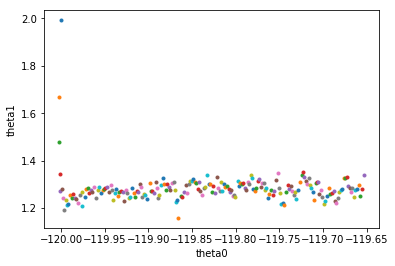

In [12]:
def h(x,theta0,theta1):
    return theta0+theta1*x

def gradient_descent(X, Y, alpha, tol):
    
    theta0, theta1 = -120,2           # initial guesses
    theta0_temp, theta1_temp = 1, 1 # so we can compare previous and new values
                                    # make sure they are different than theta0, theta1 at the start
    m = len(X)
    j = 0
    while(np.sqrt((theta0_temp - theta0)**2+(theta1_temp - theta1)**2) > tol):
        
        theta0_temp = theta0
        theta1_temp = theta1
        theta0_deriv = 0
        theta1_deriv = 0
        
        i = random.randint(0,len(X)-1)
        
        theta0_deriv += h(X[i], theta0, theta1)-Y[i]
        theta1_deriv += (h(X[i], theta0, theta1)-Y[i])*X[i]
            
        theta0 = theta0-alpha*theta0_deriv
        theta1 = theta1-alpha*theta1_deriv
        
        print(theta0,theta1)
        if j % 100 == 0:
            plt.plot(theta0,theta1,'.')
        j = j + 1

    print(f"b:{theta0}, m:{theta1}")
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    
import random
df = pd.read_csv("data/dogweights.csv")
X = df["weight"]
y = df["health status"]


gradient_descent(X,y,0.000001,0.0000001)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

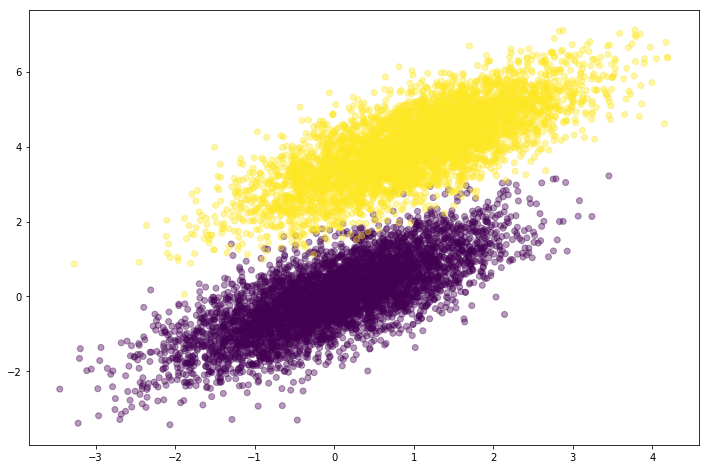

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

In [69]:
### With his function

def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)
        print(predictions)
        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
        # Print weights every so often
        if step % 10000 == 0:
            print(weights)
        
    return weights

X=[]
Y=[]
for i in range(1000):
    x = random.randint(0,100)
    X.append(x)
    if x > 50:
        Y.append(1)
    else:
        Y.append(0)

X = np.array(X)[:, np.newaxis]

weights = logistic_regression(X, Y,
                     num_steps = 5, learning_rate = 5e-5, add_intercept=True)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.

In [65]:
### with sklearn function

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, C = 1e15)
clf.fit(X, Y)

print(clf.intercept_, clf.coef_)

[-41.75067044] [[0.82787968]]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
#with my function

def h(x,theta0,theta1):
    return 1/(1+np.exp(-(theta0+theta1*x)))

def gradient_descent(X, Y, alpha, tol, nsteps):
    
    theta0, theta1 = 0, 0           # initial guesses
    theta0_temp, theta1_temp = 1, 1 # so we can compare previous and new values
                                    # make sure they are different than theta0, theta1 at the start
    theta0_deriv = 0
    theta1_deriv = 0
    m = len(X)
    j=0
    
    for j in range(nsteps):
        theta0_deriv = 0
        theta1_deriv = 0
        for i in range(m):
            theta0_deriv += h(X[i], theta0, theta1)-Y[i]
            theta1_deriv += (h(X[i], theta0, theta1)-Y[i])*X[i]
            
        theta0 = theta0-alpha*theta0_deriv
        theta1 = theta1-alpha*theta1_deriv

        
        
        if j % 100 == 0:
            print(theta0,theta1)
            plt.plot(theta0,theta1,'.')
        j = j + 1

    print(f"b:{theta0}, m:{theta1}")
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    
gradient_descent(X,Y, 5e-5, 0.0001, 300000)

KeyboardInterrupt: 

[-0.00045] [0.616675]
[-1.17526926] [0.14033501]
[-2.28056367] [0.20485584]
[-3.34951406] [0.27824593]
[-4.39393607] [0.35827329]
[-5.42116225] [0.44374888]
[-6.4358332] [0.53368235]
[-7.4404299] [0.61454474]
[-8.42593003] [0.63702325]
[-9.38268151] [0.64726817]
[-10.31029097] [0.6539494]
[-11.20911228] [0.51544085]
[-12.05310335] [0.6866316]
[-12.81247143] [0.91571639]
[-13.5355925] [0.33484087]
[-14.19905556] [1.91624369]
[-14.85828995] [0.45449753]
[-15.40240914] [1.95439652]
[-16.00547004] [0.13036656]
[-16.46772871] [0.24227784]
[-16.9519479] [0.69718069]
[-17.4325579] [1.06618]
[-17.91971006] [1.25709045]
[-18.40478798] [0.31460737]
[-18.85319992] [1.93792155]
[-19.36374612] [0.27461768]
[-19.88110568] [0.29525714]


KeyboardInterrupt: 

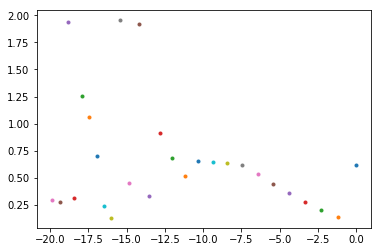

In [48]:
def h(x,theta0,theta1):
    return 1/(1+np.exp(-(theta0+theta1*x)))

def gradient_descent(X, Y, alpha, tol):
    
    theta0, theta1 = 0, 0           # initial guesses
    theta0_temp, theta1_temp = 1, 1 # so we can compare previous and new values
                                    # make sure they are different than theta0, theta1 at the start
    m = len(X)
    j=0
    
    while(np.sqrt((theta0_temp - theta0)**2+(theta1_temp - theta1)**2) > tol):
        
        theta0_temp = theta0
        theta1_temp = theta1
        theta0_deriv = 0
        theta1_deriv = 0

        for i in range(m):
            theta0_deriv += h(X[i], theta0, theta1)-Y[i]
            theta1_deriv += (h(X[i], theta0, theta1)-Y[i])*X[i]
            
        theta0 = theta0-alpha*theta0_deriv
        theta1 = theta1-alpha*theta1_deriv
        
        
        if j % 100 == 0:
            print(theta0,theta1)
            plt.plot(theta0,theta1,'.')
        j = j + 1

    print(f"b:{theta0}, m:{theta1}")
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    
gradient_descent(X,Y,5e-5,0.0001)

In [55]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    print(features)
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)
        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
    for i in range(m):
        theta0_deriv += h(X[i], theta0, theta1)-Y[i]
        theta1_deriv += (h(X[i], theta0, theta1)-Y[i])*X[i]

    theta0 = theta0-alpha*theta0_deriv
    theta1 = theta1-alpha*theta1_deriv

        
        # Print weights every so often
#         if step % 10000 == 0:
#             print(weights)
        print(weights)
    return weights

weights = logistic_regression(X, Y,
                     num_steps = 5, learning_rate = 5e-5, add_intercept=True)

[[ 1. 82.]
 [ 1. 68.]
 [ 1. 94.]
 ...
 [ 1. 80.]
 [ 1. 93.]
 [ 1. 31.]]
[-4.50000e-04  6.16675e-01]
[-0.02526768 -0.02413027]
[-0.01305404  1.41066633]
[-0.03817598  0.76894337]
[-0.06309314  0.1277421 ]


In [109]:
### With his function

def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
    print('his', weights)
        # Print weights every so often
#         if step % 10000 == 0:
#             print(weights)
    alpha = learning_rate
    theta0, theta1 = 0,0
    for j in range(num_steps):
        theta0_deriv = 0
        theta1_deriv = 0
        for i in range(len(X)):
            theta0_deriv += h(X[i], theta0, theta1)-Y[i]
            theta1_deriv += (h(X[i], theta0, theta1)-Y[i])*X[i]
            
        theta0 = theta0-alpha*theta0_deriv
        theta1 = theta1-alpha*theta1_deriv
    print('laurenn', theta0, theta1)
        
    return weights

X=[]
Y=[]
for i in range(1000):
    x = random.randint(0,100)
    X.append(x)
    if x > 50:
        Y.append(1)
    else:
        Y.append(0)

X = np.array(X)[:, np.newaxis]


# df = pd.read_csv("data/dogweights.csv")

# X = np.array(df['weight'])[:, np.newaxis]
# Y = df["health status"]

weights = logistic_regression(X, Y,
                     num_steps = 100000, learning_rate = 5e-5, add_intercept=True)

his [-33.46195377   0.65957843]


KeyboardInterrupt: 

In [107]:
# X = df.drop(columns = ["health status"])
# y = df["health status"]

model = LogisticRegression(solver="lbfgs")
model.fit(X, Y)
print(model.score(X,Y))
print(model.intercept_, model.coef_)

1.0
[-127.70937901] [[2.5263264]]
